# Clinical Cohort Matching

## Import Statements & Random Seeding

In [1]:
# ---------------------------------------------------
# Imports core libraries for data handling and visualization.
# (pandas, numpy, seaborn, matplotlib, etc.)
# ---------------------------------------------------
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.patheffects as PathEffects

# ---------------------------------------------------
# Loads additional modules for machine learning, statistical testing, and optimization.
# (tqdm for progress tracking, sklearn for modeling, scipy for optimization and distances)
# ---------------------------------------------------
from tqdm import tqdm
from sklearn.preprocessing import QuantileTransformer
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from scipy.stats import ks_2samp
from scipy.stats import wasserstein_distance

# ---------------------------------------------------
# Sets a fixed random seed to ensure reproducibility of results.
# ---------------------------------------------------
N_PATIENTS = 500   # Options: 50, 100, 1000, etc.
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# ---------------------------------------------------
# Prepares the environment for advanced analyses by integrating progress tracking and preprocessing tools.
# (tqdm, QuantileTransformer, etc. provide utilities for efficient processing and debugging.)
# ---------------------------------------------------


## Generate Sample Dataset

In [2]:
def generate_patient_dataset(n_patients, seed):
    """
    Generates a synthetic patient dataset with:
      - Two treatment variables:
          * Treatment_1: Driven by a steep logistic function on Age.
                         Patients older than ~55 have nearly 100% probability.
          * Treatment_2: Based on BMI percentile, with a moderate effect.
      - Four clinical measurements: Age, BMI, BloodPressure, and Cholesterol.
        * Age is uniformly distributed between 30 and 80.
        * For BMI, BloodPressure, and Cholesterol, treated patients have higher variance.
      - Three disease indicators via logistic functions:
          * Disease_BMI: ~50% probability at BMI ≈ 25.
          * Disease_Chol: ~50% probability at Cholesterol ≈ 210.
          * Disease_BP: ~50% probability at BP ≈ 125.
      - An overall Disease indicator set to 1 if at least two diseases are positive (~50% prevalence).
      - Group labels for each treatment (used later for matching and visualization).
    """

    # ----------------------------------------------------------------
    # (1) Ensure reproducibility by setting the random seed.
    # ----------------------------------------------------------------
    np.random.seed(seed)

    # ----------------------------------------------------------------
    # (2) Generate basic data: Create Patient_IDs and simulate Age.
    # ----------------------------------------------------------------
    patid = np.arange(1, n_patients + 1)
    Age = np.random.randint(30, 81, size=n_patients)
    df = pd.DataFrame({'Patient_ID': patid, 'Age': Age})

    # ----------------------------------------------------------------
    # (3) Compute age percentiles and assign Treatment_1 probabilities:
    #     Patients in the bottom 20% and top 20% (by Age) get 40% probability.
    # ----------------------------------------------------------------
    low_threshold = np.percentile(df['Age'], 40)
    high_threshold = np.percentile(df['Age'], 70)
    df['Prob_Treatment_1'] = 0.0
    df.loc[df['Age'] <= low_threshold, 'Prob_Treatment_1'] = 0.40
    df.loc[df['Age'] >= high_threshold, 'Prob_Treatment_1'] = 0.40

    # ----------------------------------------------------------------
    # (4) Assign Treatment_1 using the computed probabilities.
    # ----------------------------------------------------------------
    df['Treatment_1'] = (np.random.rand(n_patients) < df['Prob_Treatment_1']).astype(int)

    # ----------------------------------------------------------------
    # (5) Generate clinical measurements with differential variability.
    #     - For BMI: Treated subjects (Treatment_1 == 1) have higher variability.
    #     - For BloodPressure: Based on 80 + 0.8*Age, with added noise (more for treated).
    #     - For Cholesterol: Based on 150 + 1.2*Age + 0.5*BMI, with different noise levels.
    # ----------------------------------------------------------------
    treated_mask = df['Treatment_1'] == 1
    control_mask = df['Treatment_1'] == 0

    bmi_treated = np.clip(np.random.normal(25, 5, treated_mask.sum()), 15, 40)
    bmi_control = np.clip(np.random.normal(25, 2, control_mask.sum()), 15, 40)
    BMI = np.empty(n_patients)
    BMI[treated_mask] = bmi_treated
    BMI[control_mask] = bmi_control
    df['BMI'] = BMI

    bp_treated = np.clip(80 + 0.8 * df.loc[treated_mask, 'Age'] +
                          np.random.normal(0, 10, treated_mask.sum()), 90, 180)
    bp_control = np.clip(80 + 0.8 * df.loc[control_mask, 'Age'] +
                          np.random.normal(0, 5, control_mask.sum()), 90, 180)
    BloodPressure = np.empty(n_patients)
    BloodPressure[treated_mask] = bp_treated
    BloodPressure[control_mask] = bp_control
    df['BloodPressure'] = BloodPressure

    chol_treated = np.clip(150 + 1.2 * df.loc[treated_mask, 'Age'] + 0.5 * df.loc[treated_mask, 'BMI'] +
                            np.random.normal(0, 15, treated_mask.sum()), 150, 300)
    chol_control = np.clip(150 + 1.2 * df.loc[control_mask, 'Age'] + 0.5 * df.loc[control_mask, 'BMI'] +
                            np.random.normal(0, 7, control_mask.sum()), 150, 300)
    Cholesterol = np.empty(n_patients)
    Cholesterol[treated_mask] = chol_treated
    Cholesterol[control_mask] = chol_control
    df['Cholesterol'] = Cholesterol

    # ----------------------------------------------------------------
    # (6) Generate Treatment_2 based on BMI percentile.
    # ----------------------------------------------------------------
    bmi_percentile = df['BMI'].rank(method='max', pct=True)
    df['Prob_Treatment_2'] = bmi_percentile
    df['Treatment_2'] = (np.random.rand(n_patients) < bmi_percentile).astype(int)

    # ----------------------------------------------------------------
    # (7) Generate disease indicators via logistic functions:
    #     - Disease_BMI (linked to BMI), Disease_Chol (linked to Cholesterol),
    #       and Disease_BP (linked to BloodPressure).
    # ----------------------------------------------------------------
    k_d1, c_d1 = 0.3, 25
    prob_d1 = 1 / (1 + np.exp(-k_d1 * (df['BMI'] - c_d1)))
    df['Disease_BMI'] = (np.random.rand(n_patients) < prob_d1).astype(int)

    k_d2, c_d2 = 0.1, 210
    prob_d2 = 1 / (1 + np.exp(-k_d2 * (df['Cholesterol'] - c_d2)))
    df['Disease_Chol'] = (np.random.rand(n_patients) < prob_d2).astype(int)

    k_d3, c_d3 = 0.1, 125
    prob_d3 = 1 / (1 + np.exp(-k_d3 * (df['BloodPressure'] - c_d3)))
    df['Disease_BP'] = (np.random.rand(n_patients) < prob_d3).astype(int)

    # ----------------------------------------------------------------
    # (8) Define the overall Disease indicator:
    #     Set to 1 if at least two individual disease outcomes are positive.
    # ----------------------------------------------------------------
    df['Disease'] = ((df['Disease_BMI'] + df['Disease_Chol'] + df['Disease_BP']) >= 2).astype(int)

    # ----------------------------------------------------------------
    # (9) Assign group labels for treatment variables:
    #     These labels will be used later to compare matching methods.
    # ----------------------------------------------------------------
    df['Group_Treatment_1'] = df['Treatment_1'].map({1: 'Treated', 0: 'Control'})
    df['Group_Treatment_2'] = df['Treatment_2'].map({1: 'Treated', 0: 'Control'})
    df['Disease_Label'] = df['Disease'].map({1: 'Disease', 0: 'Non-Disease'})

    return df

# ----------------------------------------------------------------
# Example usage:
# IMPORTANT: Before running subsequent matching or plotting code,
# you must generate the dataset and assign it to 'df_generated'.
# ----------------------------------------------------------------
df_generated = generate_patient_dataset(N_PATIENTS, seed=42)
print(df_generated.head())

   Patient_ID  Age  Prob_Treatment_1  Treatment_1        BMI  BloodPressure  \
0           1   68               0.4            1  19.028648     143.414746   
1           2   58               0.0            0  26.327474     122.633509   
2           3   44               0.4            1  26.385908     113.811374   
3           4   72               0.4            0  27.020283     141.546578   
4           5   37               0.4            1  21.408483     105.957975   

   Cholesterol  Prob_Treatment_2  Treatment_2  Disease_BMI  Disease_Chol  \
0   237.251221             0.032            0            1             1   
1   248.838839             0.688            0            0             1   
2   205.051134             0.698            1            0             0   
3   246.363868             0.780            0            0             1   
4   192.936043             0.098            0            0             0   

   Disease_BP  Disease Group_Treatment_1 Group_Treatment_2 Disease_L

## Visualize Sample Dataset Distributions

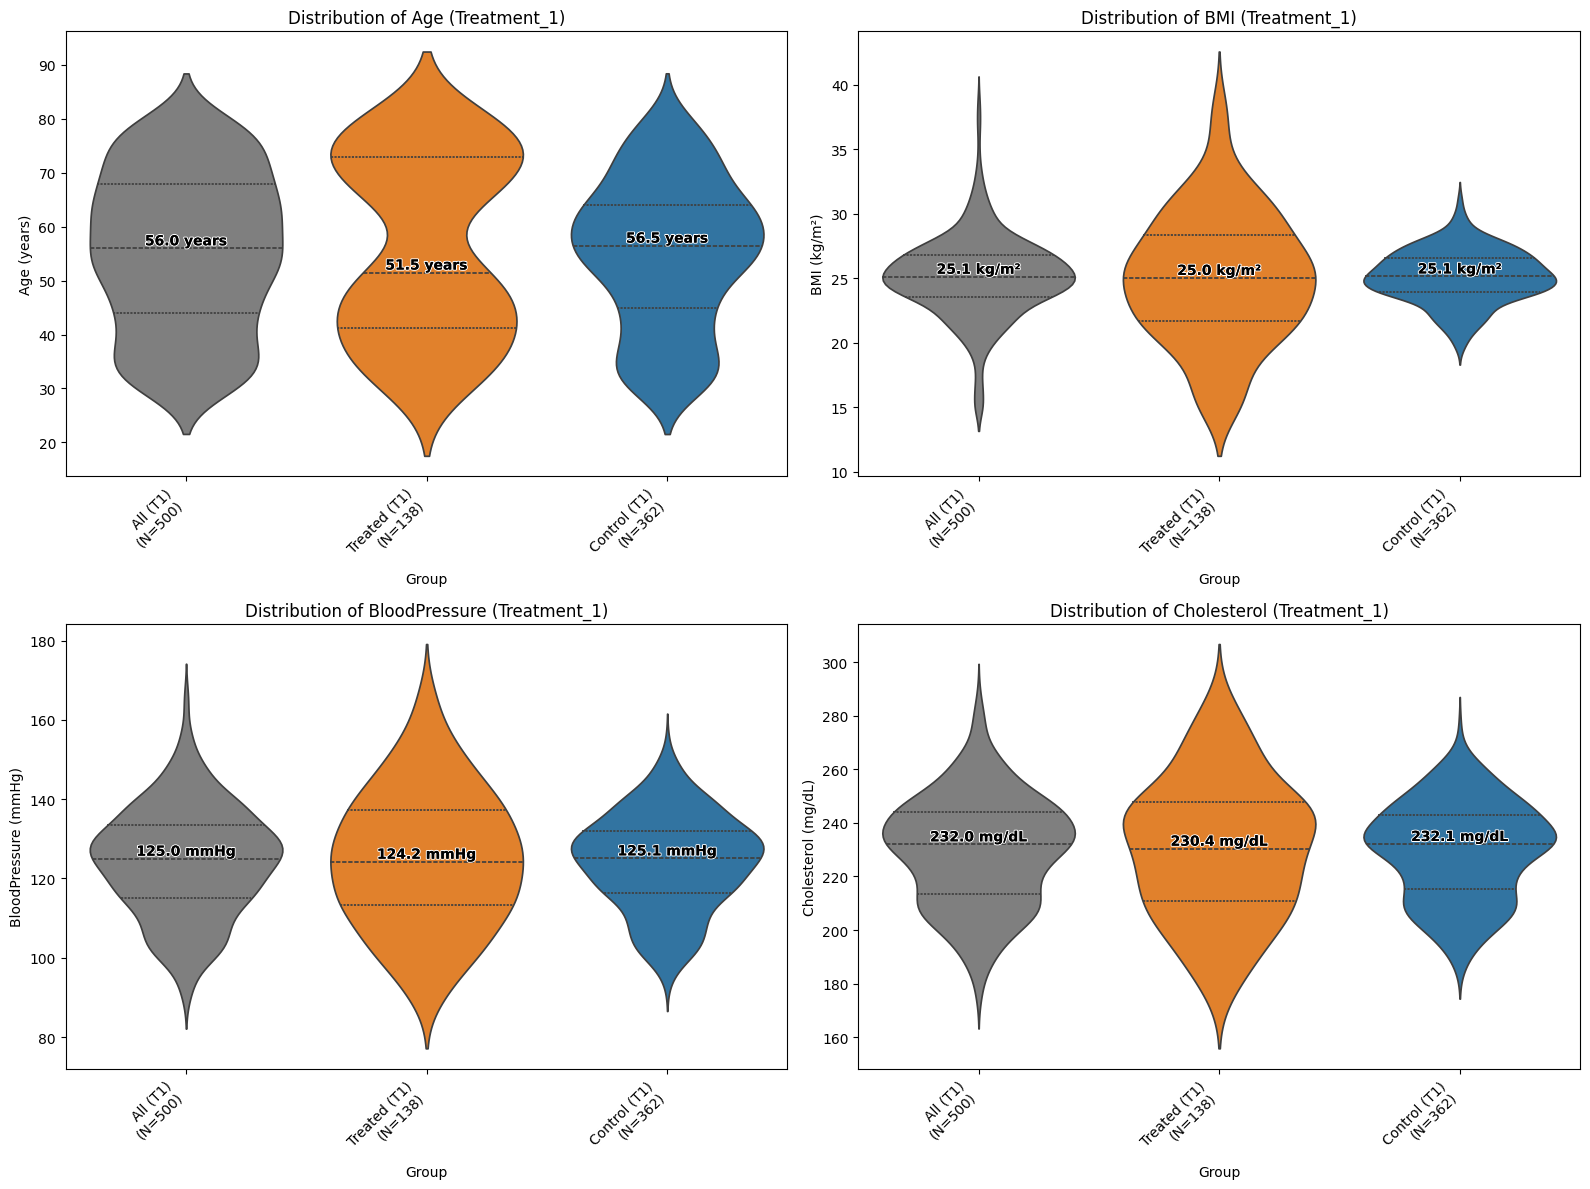

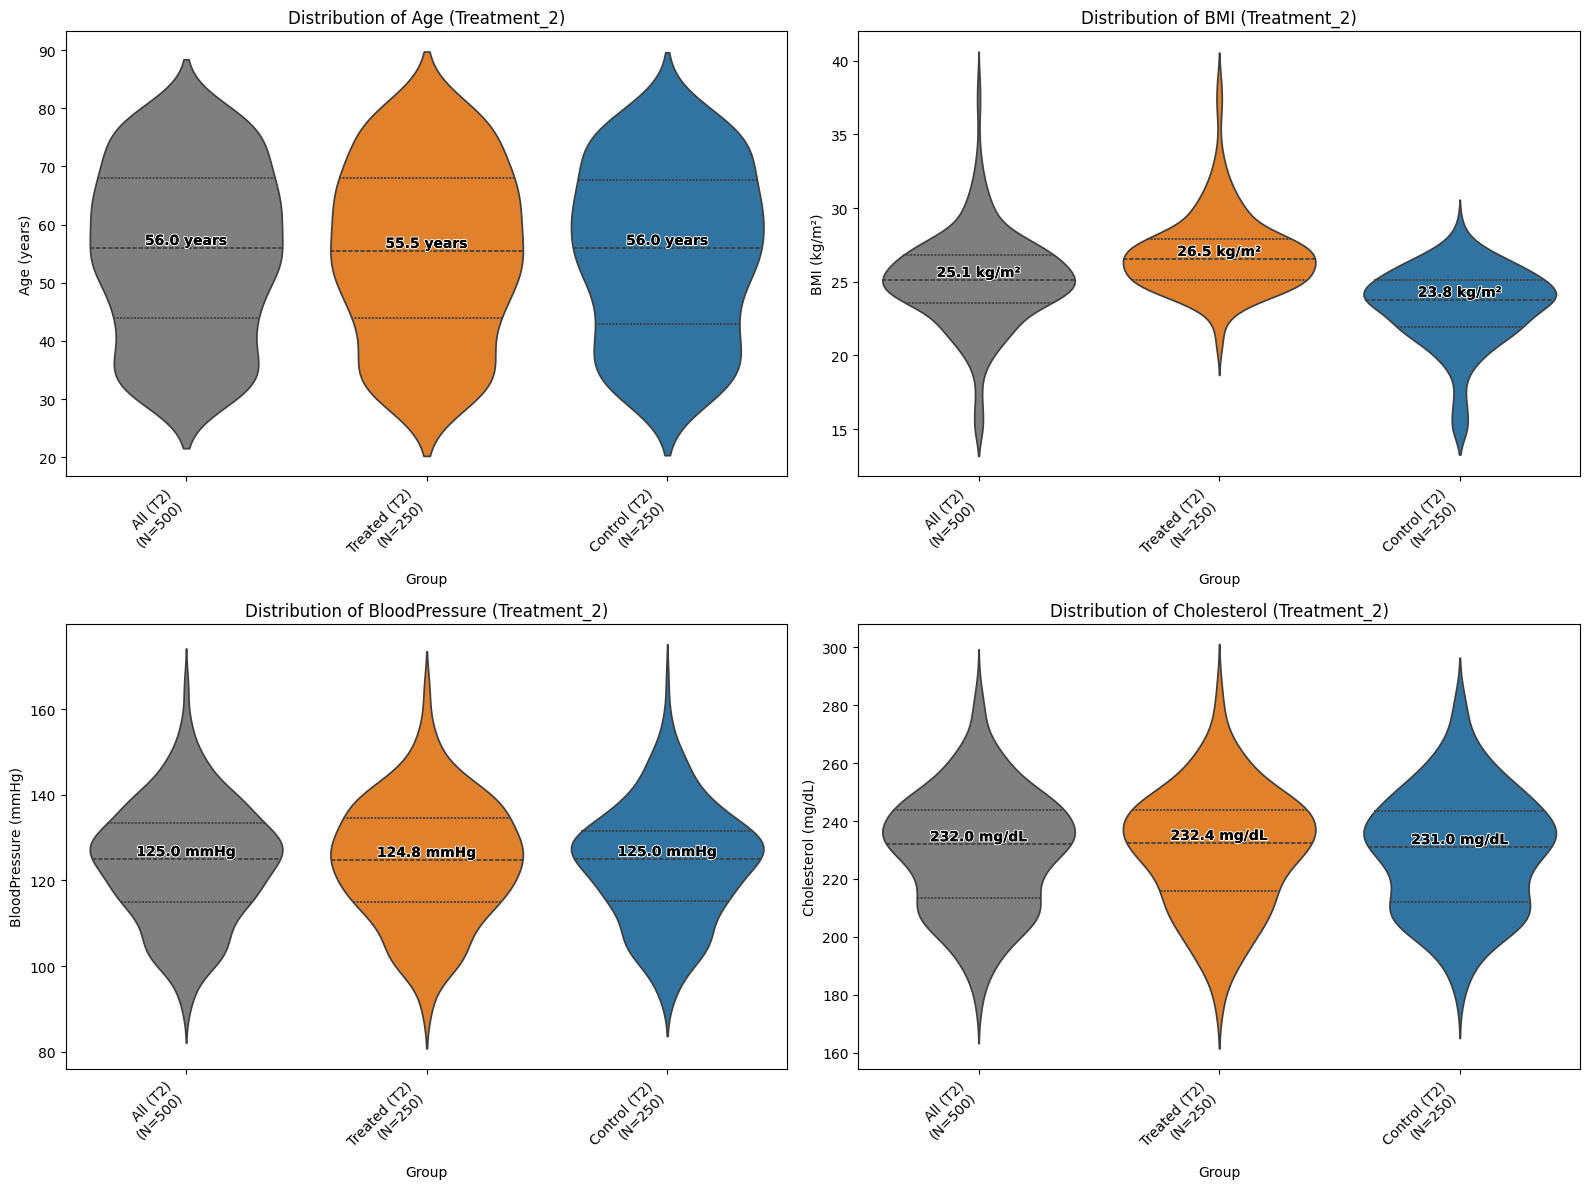

In [3]:
# ----- Define custom color mapping -----
# Bullet: Applies custom color mapping to ensure consistent and intuitive visual differentiation among groups.
custom_colors = {
    "All (T1)": "#7f7f7f",       # Neutral for overall (T1)
    "Treated (T1)": "#ff7f0e",     # Overall Treated color (T1)
    "Control (T1)": "#1f77b4",     # Overall Control color (T1)
    "All (T2)": "#7f7f7f",         # Neutral for overall (T2)
    "Treated (T2)": "#ff7f0e",     # Overall Treated color (T2)
    "Control (T2)": "#1f77b4",     # Overall Control color (T2)
}

# ----- Create plotting DataFrames for Treatment_1 -----
# Bullet: Separates the dataset into distinct groups for Treatment_1 (All, Treated, Control).
df_all_T1 = df_generated.copy()
df_all_T1['PlotGroup'] = "All (T1)"

df_treated_T1 = df_generated[df_generated['Treatment_1'] == 1].copy()
df_treated_T1['PlotGroup'] = "Treated (T1)"

df_control_T1 = df_generated[df_generated['Treatment_1'] == 0].copy()
df_control_T1['PlotGroup'] = "Control (T1)"

# Combine all groups into a single DataFrame for plotting.
df_plot_T1 = pd.concat([df_all_T1, df_treated_T1, df_control_T1])

# Prepare labels with group sizes for x-axis tick annotations.
plot_groups_T1 = ["All (T1)", "Treated (T1)", "Control (T1)"]
group_sizes_T1 = {g: len(df_plot_T1[df_plot_T1["PlotGroup"] == g]) for g in plot_groups_T1}
new_labels_T1 = [f"{g}\n(N={group_sizes_T1[g]})" for g in plot_groups_T1]

# ----- Create plotting DataFrames for Treatment_2 -----
# Bullet: Separates the dataset into distinct groups for Treatment_2 (All, Treated, Control).
df_all_T2 = df_generated.copy()
df_all_T2['PlotGroup'] = "All (T2)"

df_treated_T2 = df_generated[df_generated['Treatment_2'] == 1].copy()
df_treated_T2['PlotGroup'] = "Treated (T2)"

df_control_T2 = df_generated[df_generated['Treatment_2'] == 0].copy()
df_control_T2['PlotGroup'] = "Control (T2)"

# Combine all groups for Treatment_2.
df_plot_T2 = pd.concat([df_all_T2, df_treated_T2, df_control_T2])

# Prepare labels with group sizes.
plot_groups_T2 = ["All (T2)", "Treated (T2)", "Control (T2)"]
group_sizes_T2 = {g: len(df_plot_T2[df_plot_T2["PlotGroup"] == g]) for g in plot_groups_T2}
new_labels_T2 = [f"{g}\n(N={group_sizes_T2[g]})" for g in plot_groups_T2]

# ----- Define features and units (common to both treatments) -----
# Bullet: Defines clinical measurements and their units for consistent plotting.
features = ['Age', 'BMI', 'BloodPressure', 'Cholesterol']
units = {
    'Age': 'years',
    'BMI': 'kg/m²',
    'BloodPressure': 'mmHg',
    'Cholesterol': 'mg/dL'
}

# ----- Function to Plot Violin Plots for a Given Plotting DataFrame -----
# Bullet: Generates violin plots for each clinical measurement with embedded quartile info,
# and annotates each plot with median values (with units), rotating x-axis labels for readability.
def plot_violin_distributions(df_plot, plot_groups, new_labels, title_suffix):
    # Create a figure with a 2x2 grid of subplots.
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        ax = axes[i]
        # Create violin plot using the custom color palette and ordered groups.
        sns.violinplot(
            x="PlotGroup",
            y=feature,
            data=df_plot,
            hue="PlotGroup",
            palette=custom_colors,
            order=plot_groups,
            dodge=False,
            ax=ax,
            inner="quartile"  # Bullet: Embeds quartile information inside the violin plots.
        )

        # Set plot title and axis labels with units.
        ax.set_title(f"Distribution of {feature} {title_suffix}")
        ax.set_ylabel(f"{feature} ({units[feature]})")
        ax.set_xlabel("Group")
        ax.set_xticks(range(len(plot_groups)))
        # Rotate x-axis tick labels by 45° for improved readability.
        ax.set_xticklabels(new_labels, rotation=45, ha='right')

        # Annotate each plot with median values.
        xticks = ax.get_xticks()
        for j, group_name in enumerate(plot_groups):
            subset = df_plot[df_plot["PlotGroup"] == group_name][feature]
            if len(subset) > 0:
                median_val = subset.median()
                text = ax.text(
                    xticks[j],
                    median_val,
                    f"{median_val:.1f} {units[feature]}",  # Bullet: Includes median values with units.
                    ha='center',
                    va='bottom',
                    color='black',
                    fontsize=10,
                    fontweight='bold'
                )
                text.set_path_effects([
                    PathEffects.withStroke(linewidth=1.5, foreground='white'),
                    PathEffects.Normal()
                ])
        # Remove the legend to avoid redundancy.
        leg = ax.get_legend()
        if leg is not None:
            leg.remove()

    plt.tight_layout()
    plt.show()

# ----- Plot Violin Distributions for Treatment_1 Groups -----
plot_violin_distributions(df_plot_T1, plot_groups_T1, new_labels_T1, "(Treatment_1)")

# ----- Plot Violin Distributions for Treatment_2 Groups -----
plot_violin_distributions(df_plot_T2, plot_groups_T2, new_labels_T2, "(Treatment_2)")


## Match with Sample Treatment (1) Propensity

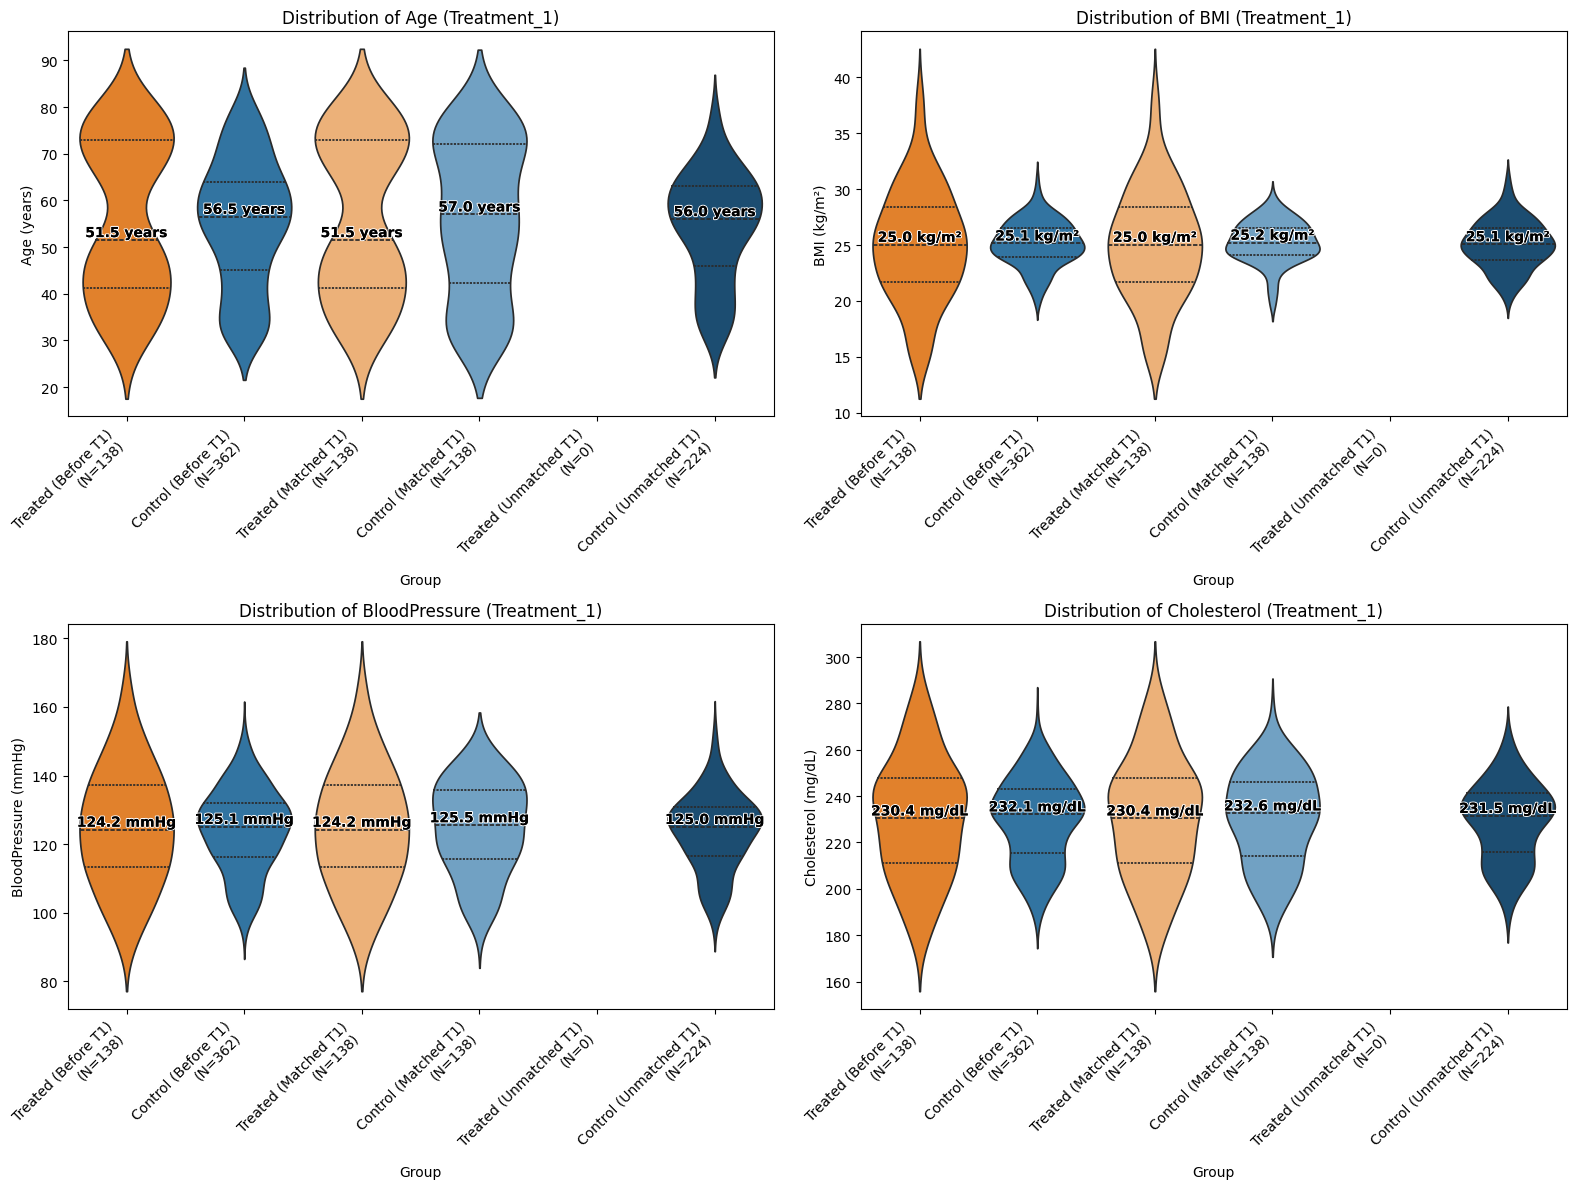

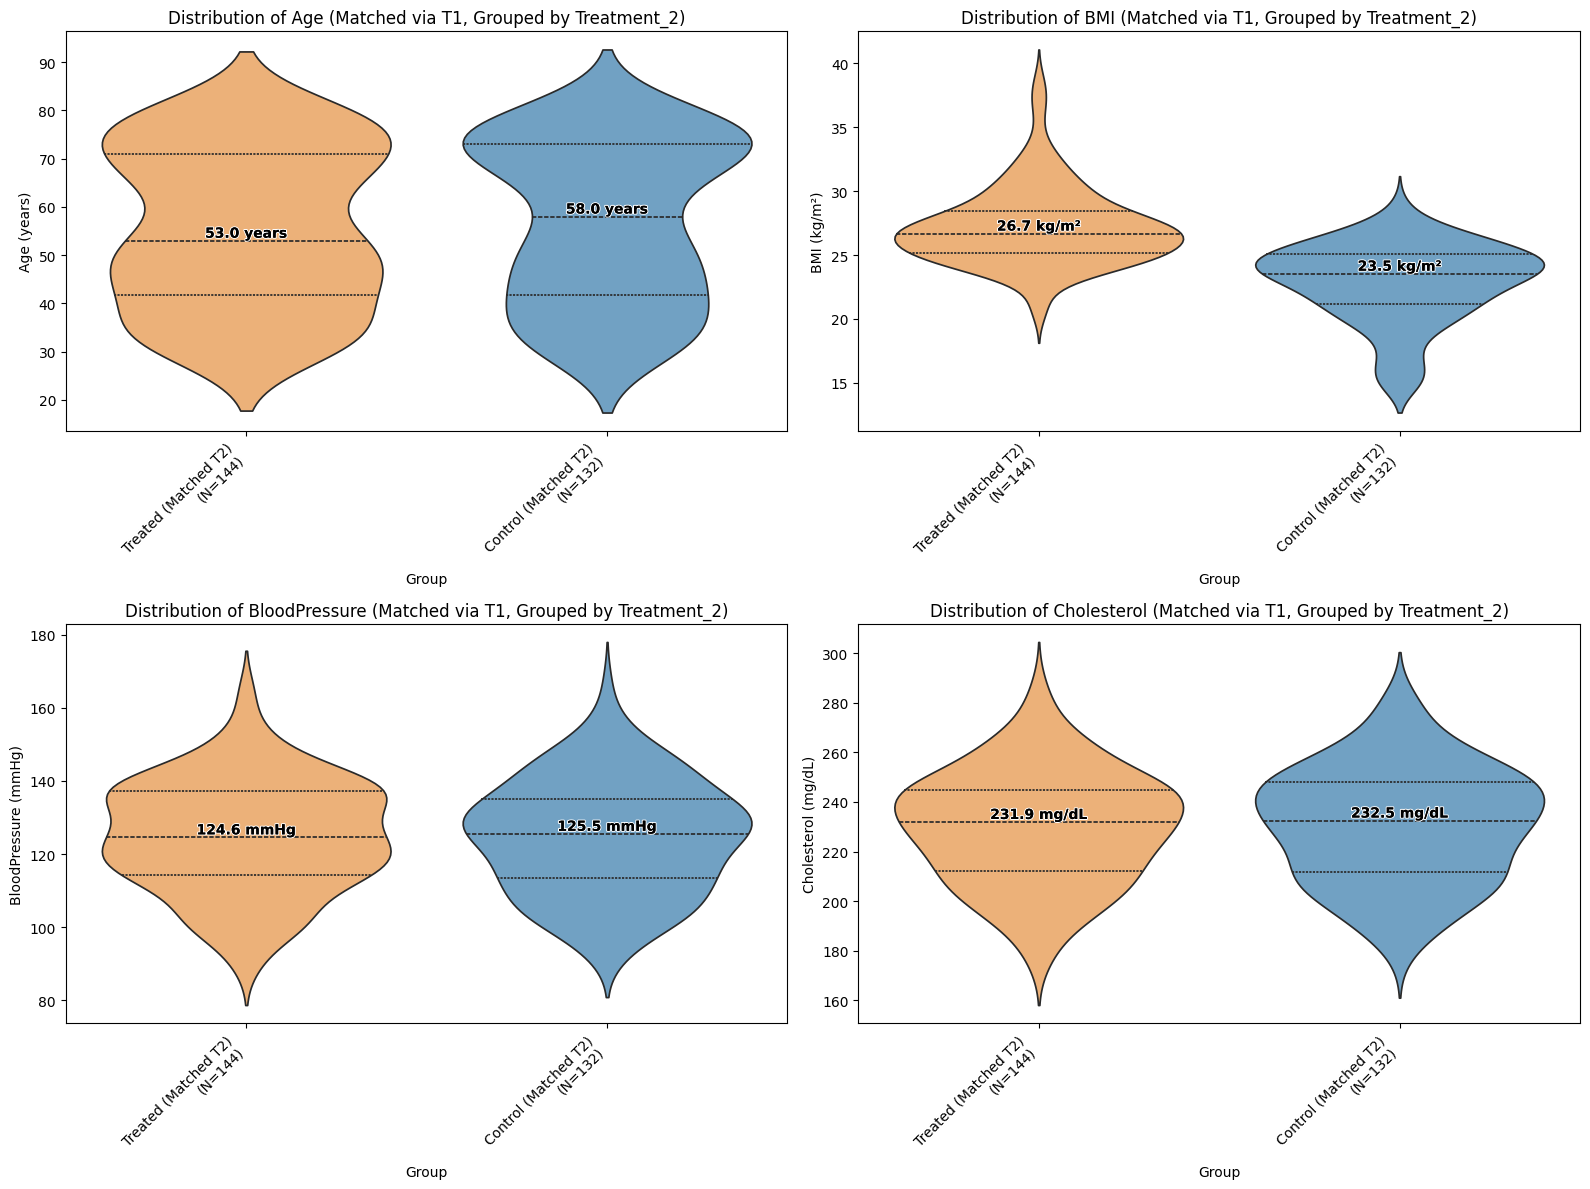

In [4]:
def propensity_matching_1to1_fast(df, match_features, random_seed):
    # -------------------------------------------------------------------------
    # Set random seed for reproducibility (ensures consistent matching results)
    # -------------------------------------------------------------------------
    np.random.seed(random_seed)

    # -------------------------------------------------------------------------
    # Check that the DataFrame contains the required 'Treatment' column.
    # -------------------------------------------------------------------------
    if 'Treatment' not in df.columns:
        raise ValueError("DataFrame must contain a 'Treatment' column (1=treated, 0=control).")

    # -------------------------------------------------------------------------
    # Check that each feature in match_features exists in the DataFrame.
    # -------------------------------------------------------------------------
    for col in match_features:
        if col not in df.columns:
            raise ValueError(f"Match feature '{col}' not found in DataFrame.")

    # -------------------------------------------------------------------------
    # Fit logistic regression to estimate sample treatment propensity scores based on clinical features.
    # (This sets up the basis for propensity matching.)
    # -------------------------------------------------------------------------
    X = df[match_features]
    y = df['Treatment']
    if y.nunique() < 2:
        # If there's no variation in treatment assignment, return empty sets.
        print("Warning: No variation in 'Treatment'. Returning empty sets.")
        empty_df = pd.DataFrame(columns=df.columns)
        return empty_df, empty_df, empty_df, empty_df

    lr_model = LogisticRegression(solver='liblinear')
    lr_model.fit(X, y)

    # -------------------------------------------------------------------------
    # Attach the estimated propensity scores to a copy of the DataFrame.
    # -------------------------------------------------------------------------
    df_copy = df.copy()
    df_copy['propensity'] = lr_model.predict_proba(X)[:, 1]

    # -------------------------------------------------------------------------
    # Split the data into treated and control groups.
    # -------------------------------------------------------------------------
    treated = df_copy[df_copy['Treatment'] == 1].copy()
    control = df_copy[df_copy['Treatment'] == 0].copy()

    if treated.empty or control.empty:
        print("Warning: One group is empty. No matches possible.")
        empty_df = pd.DataFrame(columns=df.columns)
        return empty_df, empty_df, treated, control

    # -------------------------------------------------------------------------
    # Sort both groups by propensity score (preparing for nearest-neighbor matching).
    # -------------------------------------------------------------------------
    treated.sort_values(by='propensity', inplace=True)
    control.sort_values(by='propensity', inplace=True)

    # -------------------------------------------------------------------------
    # Identify the smaller group to match against the larger group.
    # -------------------------------------------------------------------------
    if len(treated) <= len(control):
        smaller, larger = treated, control
        smaller_label = 'treated'
    else:
        smaller, larger = control, treated
        smaller_label = 'control'

    # -------------------------------------------------------------------------
    # Convert the larger group to a list of records (for efficient matching)
    # and extract sorted propensity scores.
    # -------------------------------------------------------------------------
    larger_list = list(larger.to_records(index=False))
    import bisect
    props_larger = [row['propensity'] for row in larger_list]  # Keep sorted for binary search

    matched_smaller = []
    matched_larger = []

    # -------------------------------------------------------------------------
    # For each subject in the smaller group, find the closest propensity match
    # from the larger group using the binary search (bisect) method.
    # -------------------------------------------------------------------------
    for row in smaller.to_records(index=False):
        p = row['propensity']

        # Determine the position where p fits in the sorted larger group
        idx = bisect.bisect_left(props_larger, p)
        candidates = []
        if idx < len(props_larger):
            diff = abs(props_larger[idx] - p)
            candidates.append((diff, idx))
        if idx > 0:
            diff = abs(props_larger[idx-1] - p)
            candidates.append((diff, idx-1))
        if not candidates:
            continue

        # Choose the candidate with the smallest absolute difference
        candidates.sort(key=lambda x: x[0])
        best_diff, best_idx = candidates[0]

        matched_smaller.append(row)
        matched_larger.append(larger_list[best_idx])

        # Remove the matched record to prevent re-matching
        larger_list.pop(best_idx)
        props_larger.pop(best_idx)

    # -------------------------------------------------------------------------
    # Reconstruct matched DataFrames from the matched records.
    # -------------------------------------------------------------------------
    matched_smaller_df = pd.DataFrame.from_records(matched_smaller, columns=smaller.columns)
    matched_larger_df = pd.DataFrame.from_records(matched_larger, columns=larger.columns)
    unmatched_larger_df = pd.DataFrame.from_records(larger_list, columns=larger.columns)

    # -------------------------------------------------------------------------
    # Return matched and unmatched sets in the original group order.
    # -------------------------------------------------------------------------
    if smaller_label == 'treated':
        matched_treated = matched_smaller_df
        matched_controls = matched_larger_df
        unmatched_treated = pd.DataFrame(columns=df_copy.columns)  # No unmatched in smaller group
        unmatched_controls = unmatched_larger_df
    else:
        matched_controls = matched_smaller_df
        matched_treated = matched_larger_df
        unmatched_controls = pd.DataFrame(columns=df_copy.columns)
        unmatched_treated = unmatched_larger_df

    return matched_treated, matched_controls, unmatched_treated, unmatched_controls


# =============================
# Step 1: Propensity Matching on Treatment_1
# =============================
# (Separates the dataset based on Treatment_1 for detailed subgroup analysis)
df_temp = df_generated.copy()
df_temp['Treatment'] = df_temp['Treatment_1']  # Use Treatment_1 as the treatment indicator

matched_treated_T1, matched_controls_T1, unmatched_treated_T1, unmatched_controls_T1 = propensity_matching_1to1_fast(
    df_temp,
    ['Age', 'BMI', 'BloodPressure', 'Cholesterol'],
    RANDOM_SEED
)

# Create a matched-only DataFrame for Treatment_1 for further analysis
df_matched_only_T1 = pd.concat([matched_treated_T1, matched_controls_T1], ignore_index=True)


# ----------------------------
# Step 2: Label Groups for Treatment_1 (for comparison)
# ----------------------------
# (Uses a custom color mapping and group labels to differentiate subgroups)
df_T1 = df_generated.copy()
df_T1['PlotGroup'] = np.where(df_T1['Treatment_1'] == 1, "Treated (Before T1)", "Control (Before T1)")

# For the matched groups, ensure each DataFrame has a grouping column.
for d in [matched_treated_T1, matched_controls_T1, unmatched_treated_T1, unmatched_controls_T1]:
    if 'PlotGroup_T1' not in d.columns:
        d['PlotGroup_T1'] = ""
matched_treated_T1['PlotGroup_T1'] = "Treated (Matched T1)"
matched_controls_T1['PlotGroup_T1'] = "Control (Matched T1)"
unmatched_treated_T1['PlotGroup_T1'] = "Treated (Unmatched T1)"
unmatched_controls_T1['PlotGroup_T1'] = "Control (Unmatched T1)"

# Combine all groups for plotting
dfs_T1 = [df_T1, matched_treated_T1, matched_controls_T1, unmatched_treated_T1, unmatched_controls_T1]
for d in dfs_T1:
    d.rename(columns={"PlotGroup_T1": "PlotGroup"}, inplace=True)
df_plot_T1 = pd.concat([d for d in dfs_T1 if not d.empty], ignore_index=True)

# Define the order of groups for the x-axis labels
plot_groups_T1 = [
    "Treated (Before T1)", "Control (Before T1)",
    "Treated (Matched T1)", "Control (Matched T1)",
    "Treated (Unmatched T1)", "Control (Unmatched T1)"
]


# ----------------------------
# Step 3: Within the matched Treatment_1 sample, reassign groups by Treatment_2
# ----------------------------
# (Enables side-by-side comparisons: examine how patients matched on T1 are reclassified by T2)
df_matched_T1 = df_matched_only_T1.copy()  # Already matched on T1
df_matched_T1['PlotGroup_T2'] = np.where(df_matched_T1['Treatment_2'] == 1, "Treated (Matched T2)", "Control (Matched T2)")
plot_groups_T2 = ["Treated (Matched T2)", "Control (Matched T2)"]


# ----------------------------
# Step 4: Define common plotting settings
# ----------------------------
# (Sets up clinical measurement features and corresponding units)
features = ['Age', 'BMI', 'BloodPressure', 'Cholesterol']
units = {
    'Age': 'years',
    'BMI': 'kg/m²',
    'BloodPressure': 'mmHg',
    'Cholesterol': 'mg/dL'
}

# Define a common color mapping for the plots (ensures consistent visual differentiation)
common_colors = {
    "Treated (Before T1)": "#ff7f0e",
    "Control (Before T1)": "#1f77b4",
    "Treated (Matched T1)": "#ffb166",
    "Control (Matched T1)": "#63a3d1",
    "Treated (Unmatched T1)": "#c65100",
    "Control (Unmatched T1)": "#0e4f7f",
    "Treated (Matched T2)": "#ffb166",
    "Control (Matched T2)": "#63a3d1"
}


# ----------------------------
# Step 5: Define a generic plotting function for violin plots
# ----------------------------
def plot_violin_distributions(df_plot, plot_groups, title_suffix):
    # Compute group sizes and update x-axis labels with observation counts
    group_sizes = {g: len(df_plot[df_plot["PlotGroup"] == g]) for g in plot_groups}
    new_labels = [f"{g}\n(N={group_sizes[g]})" for g in plot_groups]

    # Create subplots for the four clinical features
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    # Loop through each clinical feature and generate a violin plot
    for i, feature in enumerate(features):
        ax = axes[i]
        sns.violinplot(
            x="PlotGroup",
            y=feature,
            data=df_plot,
            hue="PlotGroup",
            palette=common_colors,
            order=plot_groups,
            dodge=False,
            ax=ax,
            inner="quartile"  # Embeds quartile information in the plot
        )
        # Set title and axis labels (includes units)
        ax.set_title(f"Distribution of {feature} {title_suffix}")
        ax.set_ylabel(f"{feature} ({units[feature]})")
        ax.set_xlabel("Group")

        # Rotate x-axis tick labels by 45° to improve readability
        ax.set_xticks(range(len(plot_groups)))
        ax.set_xticklabels(new_labels, rotation=45, ha='right')

        # Annotate each plot with the median value (with units)
        xticks = ax.get_xticks()
        for j, grp in enumerate(plot_groups):
            subset = df_plot[df_plot["PlotGroup"] == grp][feature]
            if len(subset) > 0:
                median_val = subset.median()
                txt = ax.text(
                    xticks[j],
                    median_val,
                    f"{median_val:.1f} {units[feature]}",
                    ha='center',
                    va='bottom',
                    color='black',
                    fontsize=10,
                    fontweight='bold'
                )
                txt.set_path_effects([
                    PathEffects.withStroke(linewidth=1.5, foreground='white'),
                    PathEffects.Normal()
                ])
        # Remove legend for clarity
        if ax.get_legend() is not None:
            ax.get_legend().remove()

    plt.tight_layout()
    plt.show()


# ----------------------------
# Step 6: Plot distributions for Treatment_1 groups (propensity matched)
# ----------------------------
plot_violin_distributions(df_plot_T1, plot_groups_T1, "(Treatment_1)")

# ----------------------------
# Step 7: Plot distributions for the matched sample regrouped by Treatment_2
# ----------------------------
# Rename the Treatment_2 grouping column to "PlotGroup" for consistency
df_matched_T1 = df_matched_T1.copy()
df_matched_T1.rename(columns={"PlotGroup_T2": "PlotGroup"}, inplace=True)
plot_violin_distributions(df_matched_T1, plot_groups_T2, "(Matched via T1, Grouped by Treatment_2)")


## Match with Feature Space Distance Matching

In [5]:
def match_treated_controls_feature_space(df, match_features, treatment_col, treated_label, control_label, seed):
    """
    Matches treated and control samples using feature space distance matching on quantile-normalized clinical measurements.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing clinical measurements and treatment labels.
        match_features (list): List of column names to use for matching.
        treatment_col (str): Column name that indicates treatment assignment.
        treated_label: Value indicating a treated sample.
        control_label: Value indicating a control sample.
        seed (int): Random seed for reproducibility.

    Returns:
        matched_treated (pd.DataFrame): Treated samples that were matched.
        matched_controls (pd.DataFrame): Control samples that were matched.
        unmatched_treated (pd.DataFrame): Treated samples that could not be matched.
        unmatched_controls (pd.DataFrame): Control samples that could not be matched.
    """

    # -------------------------------------------------------------------------
    # Validate and set random seed for reproducibility.
    # (Ensures that the matching results are consistent across runs.)
    # -------------------------------------------------------------------------
    np.random.seed(seed)

    # -------------------------------------------------------------------------
    # Work on a copy of the DataFrame to avoid modifying the original data.
    # -------------------------------------------------------------------------
    df_copy = df.copy()

    # -------------------------------------------------------------------------
    # Apply quantile normalization to each matching feature.
    # For each feature, compute the rank and scale it to the [0, 1] range.
    # -------------------------------------------------------------------------
    norm_features = []
    for col in match_features:
        norm_col = col + '_qn'
        # Compute average ranks for the column values.
        df_copy[norm_col] = df_copy[col].rank(method='average')
        # Scale the ranks to the [0, 1] interval.
        df_copy[norm_col] = df_copy[norm_col] / df_copy[norm_col].max()
        norm_features.append(norm_col)

    # -------------------------------------------------------------------------
    # Split the DataFrame into treated and control groups based on the treatment column.
    # -------------------------------------------------------------------------
    df_treated = df_copy[df_copy[treatment_col] == treated_label]
    df_control = df_copy[df_copy[treatment_col] == control_label]

    # -------------------------------------------------------------------------
    # Compute the cost matrix using Euclidean distances on the quantile-normalized features.
    # This matrix quantifies similarity between treated and control subjects.
    # -------------------------------------------------------------------------
    cost_matrix = cdist(df_treated[norm_features].values, df_control[norm_features].values, metric='euclidean')

    # -------------------------------------------------------------------------
    # Apply the Hungarian algorithm (linear sum assignment) to determine the optimal matching.
    # -------------------------------------------------------------------------
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # -------------------------------------------------------------------------
    # Extract the matched samples based on the assignment indices.
    # -------------------------------------------------------------------------
    matched_treated = df_treated.iloc[row_ind].copy()
    matched_controls = df_control.iloc[col_ind].copy()

    # -------------------------------------------------------------------------
    # Identify unmatched samples by checking which indices were not matched.
    # -------------------------------------------------------------------------
    matched_treated_indices = set(matched_treated.index)
    matched_control_indices = set(matched_controls.index)
    unmatched_treated = df_treated[~df_treated.index.isin(matched_treated_indices)].copy()
    unmatched_controls = df_control[~df_control.index.isin(matched_control_indices)].copy()

    # -------------------------------------------------------------------------
    # Return the matched and unmatched subsets for further subgroup analysis and visualization.
    # -------------------------------------------------------------------------
    return matched_treated, matched_controls, unmatched_treated, unmatched_controls

# =============================
# Example Usage:
# ----------------------------
# Step 1: Prepare the DataFrame for matching by ensuring it has a 'Treatment' column.
df_temp = df_generated.copy()
if "Treatment" not in df_temp.columns:
    df_temp["Treatment"] = df_temp["Treatment_1"]

# Step 2: Perform linear sum assignment matching on clinical measurements.
matched_treated_T1, matched_controls_T1, unmatched_treated_T1, unmatched_controls_T1 = match_treated_controls_feature_space(
    df_temp,
    match_features=["Age", "BMI", "BloodPressure", "Cholesterol"],
    treatment_col="Treatment",
    treated_label=1,
    control_label=0,
    seed=RANDOM_SEED
)

# Step 3: Create a matched-only DataFrame for further analysis.
df_matched_only_T1 = pd.concat([matched_treated_T1, matched_controls_T1], ignore_index=True)


## Comparing Matching Approaches

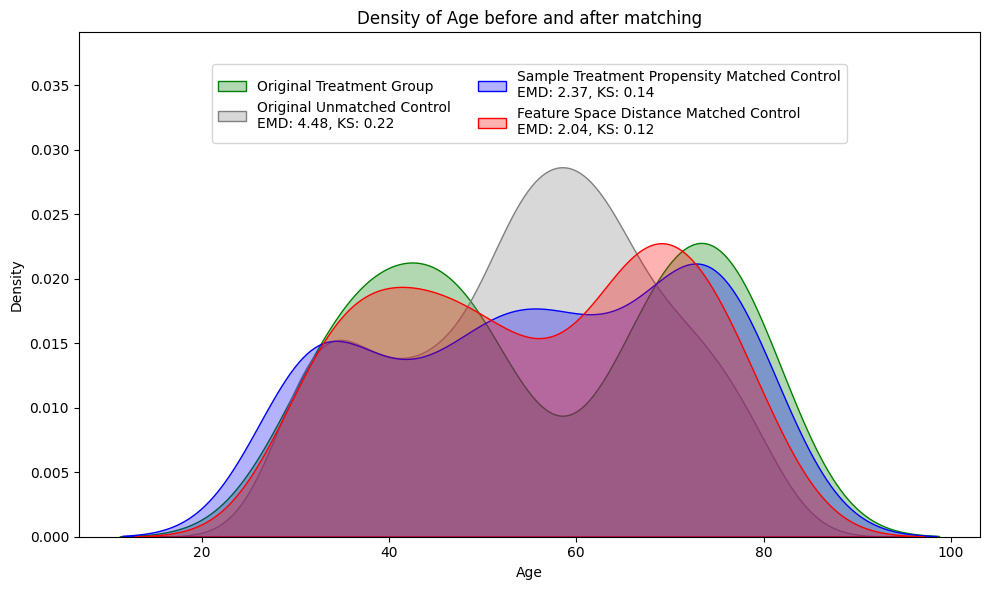

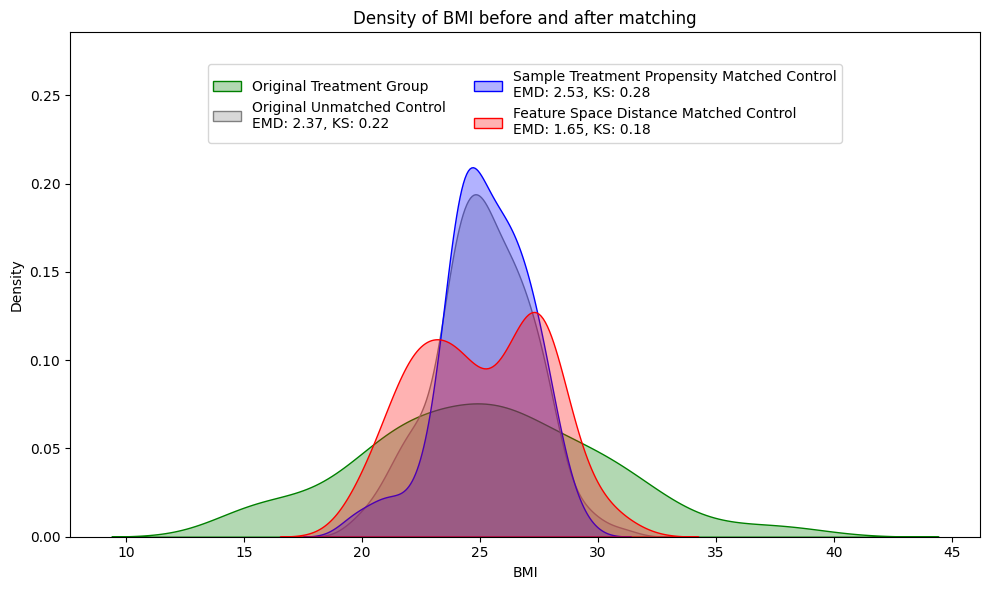

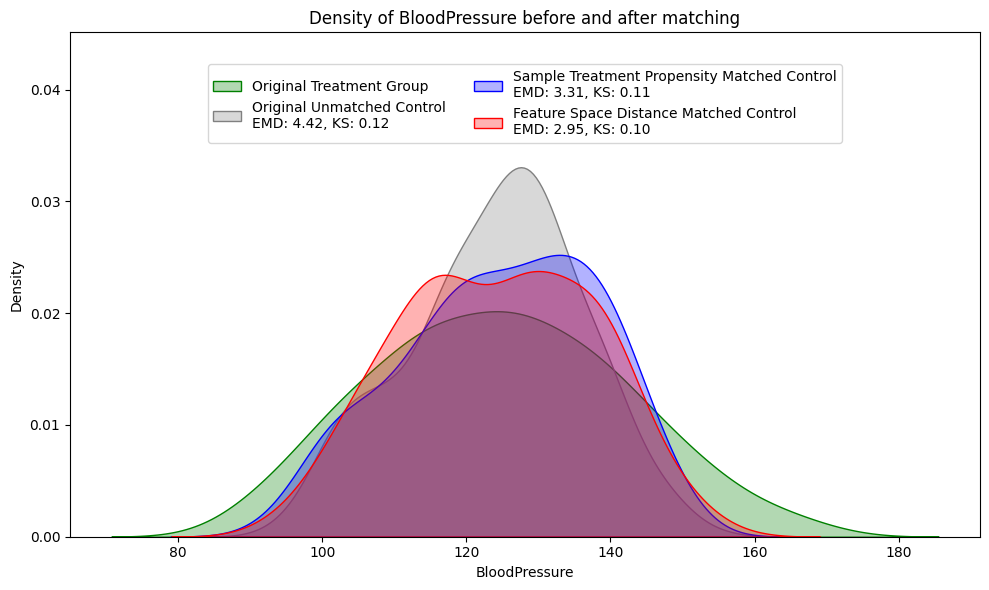

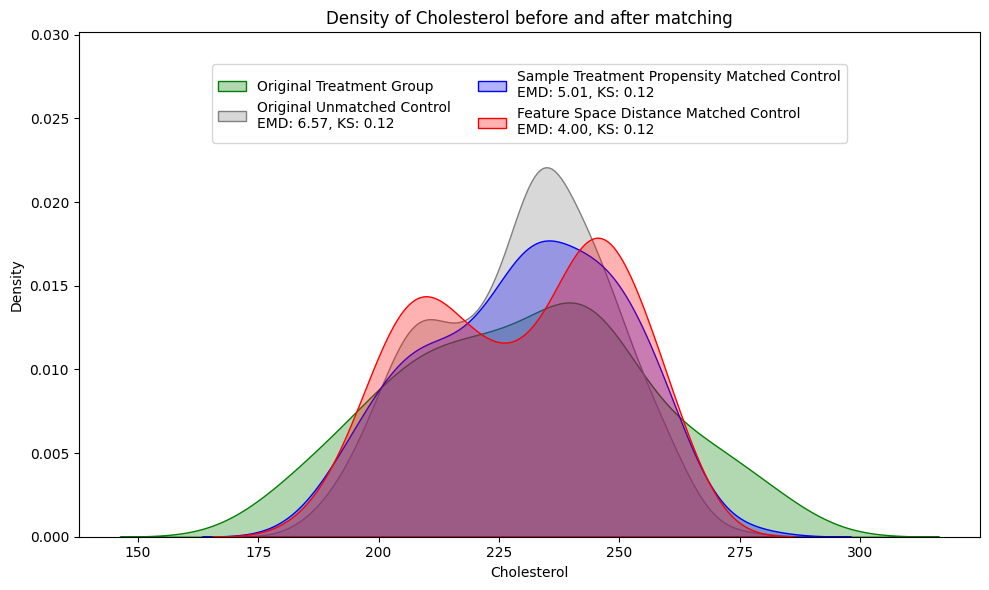

<ipython-input-6-86a53b6572e6>:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


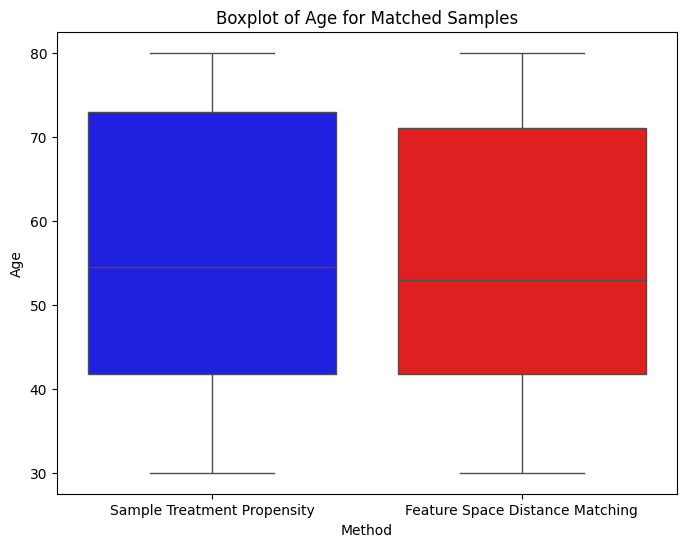

<ipython-input-6-86a53b6572e6>:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


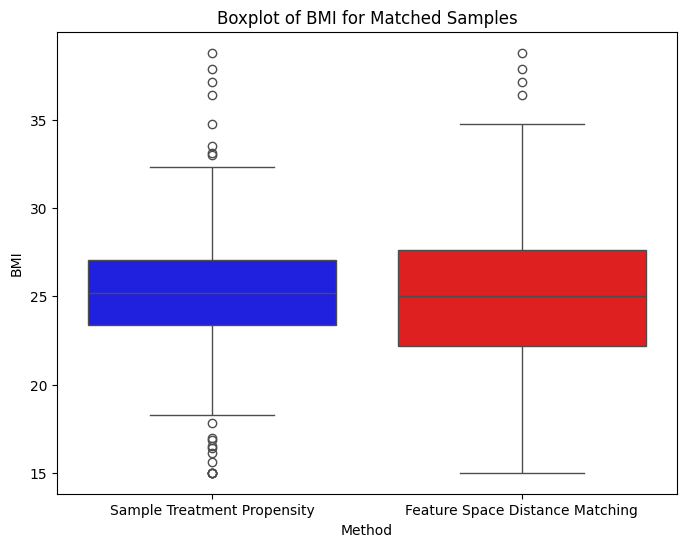

<ipython-input-6-86a53b6572e6>:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


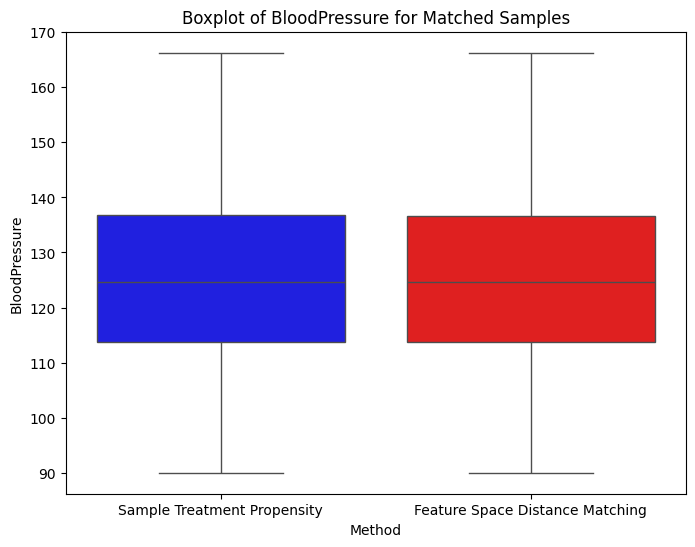

<ipython-input-6-86a53b6572e6>:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


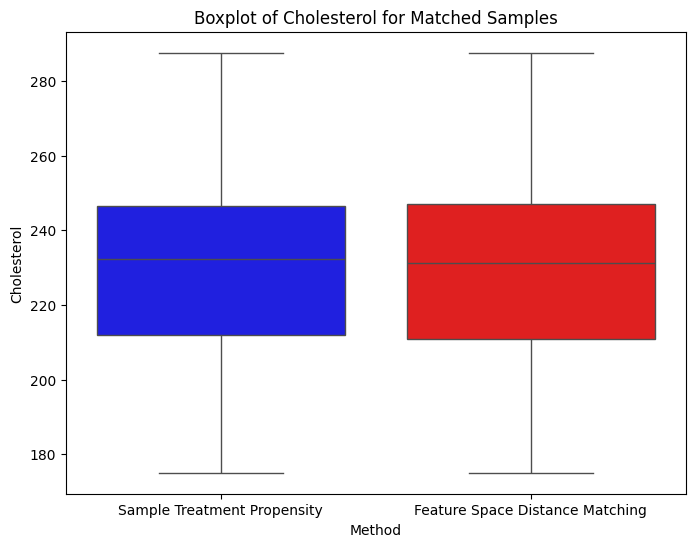

In [6]:
def demonstrate_matching_differences(df):
    """
    Runs both sample treatment propensity matching (based on Treatment_1) and feature space distance matching
    (using clinical measurements) on the input dataset. Then, it generates density plots and
    boxplots for the clinical measurements (Age, BMI, BloodPressure, Cholesterol) comparing:
      - The original (pre‐matching) sample,
      - The propensity-matched sample (using Treatment_1),
      - The feature space distance matched sample.
    The design of the dataset is such that Treatment_1 is almost perfectly driven by Age,
    while BMI, BP, and Cholesterol are only weakly correlated with Age. Thus, propensity matching
    will balance Age well but leave residual imbalances in BMI, BP, and Cholesterol compared to
    feature space distance matching.
    """

    # ================================================================
    # Implement two distinct matching strategies on the same dataset.
    # ================================================================

    # --- Propensity Matching on Treatment_1 ---
    # Uses logistic regression on clinical features to compute propensity scores,
    # then matches subjects based on score proximity.
    df_prop = df.copy()
    df_prop["Treatment"] = df_prop["Treatment_1"]  # Use Treatment_1 for sample treatment propensity matching.
    matched_treated_prop, matched_controls_prop, unmatched_treated_prop, unmatched_controls_prop = propensity_matching_1to1_fast(
        df_prop,
        ['Age', 'BMI', 'BloodPressure', 'Cholesterol'],
        RANDOM_SEED
    )
    df_matched_prop = pd.concat([matched_treated_prop, matched_controls_prop], ignore_index=True)

    # --- Feature Space Distance Matching on Clinical Measurements ---
    # Applies quantile normalization to clinical measurements, computes a cost matrix via Euclidean distances,
    # and uses the Hungarian algorithm for optimal matching.
    df_lin = df.copy()
    df_lin["Treatment"] = df_lin["Treatment_1"]  # Use the same treatment definition for consistency.
    matched_treated_lin, matched_controls_lin, unmatched_treated_lin, unmatched_controls_lin = match_treated_controls_feature_space(
        df_lin,
        match_features=["Age", "BMI", "BloodPressure", "Cholesterol"],
        treatment_col="Treatment",
        treated_label=1,
        control_label=0,
        seed=RANDOM_SEED
    )
    df_matched_lin = pd.concat([matched_treated_lin, matched_controls_lin], ignore_index=True)

    # ================================================================
    # Generate density plots to visually compare distributions.
    # ================================================================
    # Define the list of clinical features for plotting.
    features = ['Age', 'BMI', 'BloodPressure', 'Cholesterol']

    # Define helper functions to compute quantitative balance metrics.
    def calculate_emd(df1, df2, feature):
        # Compute Earth Mover's Distance (EMD) between two distributions.
        return wasserstein_distance(df1[feature], df2[feature])

    def calculate_ks(df1, df2, feature):
        # Compute the KS test statistic between two distributions.
        ks_stat, p_value = ks_2samp(df1[feature], df2[feature])
        return ks_stat

    # For each clinical measurement, generate a density plot comparing:
    # - Original treatment group,
    # - Original unmatched control group,
    # - Sample Treatment Propensity matched controls,
    # - Feature Space Distance matched controls.
    for feature in features:
        plt.figure(figsize=(10, 6))

        # Plot density for original treatment group.
        sns.kdeplot(
            df[df['Treatment_1'] == 1][feature],
            label='Original Treatment Group',
            color='green', fill=True, alpha=0.3
        )

        # Plot density for original unmatched control group.
        sns.kdeplot(
            df[df['Treatment_1'] == 0][feature],
            label='Original Unmatched Control',
            color='grey', fill=True, alpha=0.3
        )

        # Plot density for sample treatment propensity-matched controls.
        sns.kdeplot(
            df_matched_prop[df_matched_prop['Treatment_1'] == 0][feature],
            label='Sample Treatment Propensity Matched Control',
            color='blue', fill=True, alpha=0.3
        )

        # Plot density for feature space distance matched controls.
        sns.kdeplot(
            df_matched_lin[df_matched_lin['Treatment_1'] == 0][feature],
            label='Feature Space Distance Matched Control',
            color='red', fill=True, alpha=0.3
        )

        # Compute EMD and KS distances for each matching strategy.
        emd_unmatched_ctrl = calculate_emd(df[df['Treatment_1'] == 0], df[df['Treatment_1'] == 1], feature)
        emd_unmatched_prop = calculate_emd(df_matched_prop[df_matched_prop['Treatment_1'] == 0], df[df['Treatment_1'] == 1], feature)
        emd_unmatched_lin = calculate_emd(df_matched_lin[df_matched_lin['Treatment_1'] == 0], df[df['Treatment_1'] == 1], feature)

        ks_unmatched_ctrl = calculate_ks(df[df['Treatment_1'] == 0], df[df['Treatment_1'] == 1], feature)
        ks_unmatched_prop = calculate_ks(df_matched_prop[df_matched_prop['Treatment_1'] == 0], df[df['Treatment_1'] == 1], feature)
        ks_unmatched_lin = calculate_ks(df_matched_lin[df_matched_lin['Treatment_1'] == 0], df[df['Treatment_1'] == 1], feature)

        # Create a legend with quantitative distance metrics included.
        legend_labels = [
            "Original Treatment Group",
            f"Original Unmatched Control\nEMD: {emd_unmatched_ctrl:.2f}, KS: {ks_unmatched_ctrl:.2f}",
            f"Sample Treatment Propensity Matched Control\nEMD: {emd_unmatched_prop:.2f}, KS: {ks_unmatched_prop:.2f}",
            f"Feature Space Distance Matched Control\nEMD: {emd_unmatched_lin:.2f}, KS: {ks_unmatched_lin:.2f}"
        ]

        plt.title(f"Density of {feature} before and after matching")
        plt.xlabel(feature)
        plt.ylabel("Density")

        # Place legend at the top and adjust Y-axis for clarity.
        plt.legend(labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2)
        plt.ylim(0, plt.gca().get_ylim()[1] * 1.3)

        plt.tight_layout()
        plt.show()

    # ================================================================
    # Generate side-by-side boxplots to compare covariate distributions.
    # ================================================================
    # Add a column to indicate the matching method for comparison.
    df_prop_temp = df_matched_prop.copy()
    df_prop_temp['Method'] = 'Sample Treatment Propensity'

    df_lin_temp = df_matched_lin.copy()
    df_lin_temp['Method'] = 'Feature Space Distance Matching'

    df_matched_all = pd.concat([df_prop_temp, df_lin_temp], ignore_index=True)

    for feature in features:
        plt.figure(figsize=(8, 6))
        sns.boxplot(
            x='Method', y=feature, data=df_matched_all,
            palette={'Sample Treatment Propensity':'blue','Feature Space Distance Matching':'red'}
        )
        plt.title(f"Boxplot of {feature} for Matched Samples")
        plt.show()

# Run the demonstration function on the generated dataset.
demonstrate_matching_differences(df_generated)
